## Implementation of The Pre-Trained Efficientnet model development and fine tuning

In these Notebook , I load the EfficientnetB7 model and fine tune it as below 

1. **Optimizers** - I will use ; 1. `SGD`,2. `RMSprop`,3. `Adam`,4. `Adagrad`,5. `Adadelta` and determine which One to use for the new model
2. **Number of epochs** - `1 2 5 10` respective training
3. **Batch size** - Optimum Batch size ; `8, 16`. 
4. **Dropout** - we will optimise the dropout of the model, values `0.5, 0.6, 0.7, 0.8, 0.9`

> **Section one:** Common Function Creation and preloaded model with parameteres : **Batch size** `8`, **Optimizer** `Adam`, **Number of epochs** `4`, **dropout value** `0.5`

In [1]:
#Importing the Libraries
import pandas as pd
import numpy as np
import os
import math
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import efficientnet.keras as efn 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook
import time
import tqdm.gui as tqdm
import tqdm.notebook as tqdm

2023-04-15 15:28:39.156783: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-15 15:28:39.196020: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-15 15:28:39.196573: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 15:28:39.896030: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
#Data Preprocessing 

def get_data_generator(train_data_path, \
                       val_data_path, \
                       targetsize, \
                       classmode, \
                       batchsize):
    """
    This function is a data generator function for train, validation, and testing data
    Inputs
        train_data_path   : train data path for the dataset 
        val_data_path     : validation data path for the dataset
        targetsize        : target size for the generator to resize all images to, (224,224)
        classmode         : class mode, 'categorical'
        batchsize         : batch size
    Outputs
        train_generator   : generated train data
        val_generator     : generated validation data
    
    """
    train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
    val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    
    train_generator=train_datagen.flow_from_directory(train_data_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize,
                                                 color_mode='rgb',
                                                 batch_size=batchsize,
                                                 class_mode=classmode,
                                                 shuffle=True)
    
    val_generator=val_datagen.flow_from_directory(val_data_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize,
                                                 color_mode='rgb',
                                                 batch_size=batchsize,
                                                 class_mode=classmode,)
 
    return train_generator,val_generator  
    

def train_evaluate_the_model(train_generator, \
                             val_generator, \
                             optimizer, \
                             epochs, \
                             dropout_value, \
                             TheModel):
    '''
    train the model, do predictions, and do evaluation and return the accuracy of the model
    Inputs
        train_generator : generated train data
        val_generator   : generated validation data
        optimizer       : the optimizer method used to compile the model
        epochs          : the epochs of the model use to fit the model
        dropout_value   : the dropout value
        TheModel        : The pretrained model loaded,
    Outputs
        accuracy        : The accuracy of the model
    '''
    # load pretrained model and add layers on top of the model
    x = TheModel.output
    x = tf.keras.layers.Flatten()(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dropout(dropout_value)(x)
    predictions = Dense(4, activation="sigmoid")(x)
    model = Model(inputs = TheModel.input, outputs = predictions)
    
    # freeze base layers for training
    for layer in TheModel.layers:
        layer.trainable = False
    
    # compile the model
    model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    step_size_train=train_generator.n//train_generator.batch_size
    # fit the model
    r = model.fit_generator(generator=train_generator,
                        validation_data=val_generator,
                        steps_per_epoch=step_size_train,
                        epochs=epochs)
    # valuate the model
    scores = model.evaluate(val_generator)
    accuracy = scores[1]*100
    
    return accuracy, model

In [3]:
'''
import zipfile
from google.colab import drive

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Datasets.zip", 'r')
zip_ref.extractall("")
zip_ref.close()
'''

'\nimport zipfile\nfrom google.colab import drive\n\ndrive.mount(\'/content/drive/\')\n\nzip_ref = zipfile.ZipFile("/content/drive/MyDrive/Datasets.zip", \'r\')\nzip_ref.extractall("")\nzip_ref.close()\n'

In [4]:
ROOT_DIR = "Datasets"
number_of_images = {}

#This code lists the Amounts of Healthy and Non-healthy Brain Tumor Datasets
for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))

number_of_images.items()


dict_items([('Testing', 4), ('Training', 4), ('Validation', 4)])

In [5]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) 
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

'''
Initial and constant parameters for the model
initial parameters
       batch_size    : the initial batch size we will create our base model with
Constant parameters
       target_size   : Constant image target size for the whole notebook which is (224,224)
       class_mode    : class mode we will use for the whole notebook, which is 'categorical'
'''
# constant parameters
targetsize_constant = (224,224)
classmode_constant = 'categorical'

# initial parameters
batchsize_initial = 8
epochs_initial = 4
dropout_value_initial = 0.5
optimizer_initial = 'Adam'

# Data paths
train_dataset_path = 'Datasets/Training/'
validation_dataset_path = 'Datasets/Validation/'
test_dataset_path = 'Datasets/Testing/'


train_generator_initial = train_datagen.flow_from_directory(train_dataset_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize_constant,
                                                 color_mode='rgb',
                                                 batch_size=batchsize_initial,
                                                 class_mode=classmode_constant,
                                                 shuffle=True)
val_generator_initial = val_datagen.flow_from_directory(validation_dataset_path, # this is where you specify the path to the main data folder
                                                 target_size=targetsize_constant,
                                                 color_mode='rgb',
                                                 batch_size=batchsize_initial,
                                                 class_mode=classmode_constant,
                                                 shuffle=True)


Found 2870 images belonging to 4 classes.
Found 7023 images belonging to 4 classes.


In [6]:
# display classes found in the data
train_generator_initial.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [7]:
#Importing the EffnetB7 model
from tensorflow.keras.applications import EfficientNetB7

In [8]:
image_size = [224,224] # choose image size
# import the base model
efnB7 = tf.keras.applications.efficientnet.EfficientNetB7(input_shape= image_size+[3],weights='imagenet',include_top=False)

# storing the base model in the kernel for later use to avoid loading many times
efnB7_basemodel = efnB7


2023-04-15 13:02:56.255365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-15 13:02:56.255917: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [9]:
#Adding the Layers to the Model
# initial parameter value

dropout_value_initial = 0.1

# add layers
x = efnB7.output
x = tf.keras.layers.Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(dropout_value_initial)(x)
predictions = Dense(4, activation="sigmoid")(x)
model = Model(inputs = efnB7.input, outputs = predictions)# initial parameter value
dropout_value_initial = 0.1

# add layers
x = efnB7.output
x = tf.keras.layers.Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
x = Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(dropout_value_initial)(x)
predictions = Dense(4, activation="sigmoid")(x)
model = Model(inputs = efnB7.input, outputs = predictions)

In [10]:
#Model compilation
# initial optimizer
optimizer_initial = 'Adam'

# compile the model
model.compile(optimizer=optimizer_initial,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
#Model fitting 
# initial parameters
epochs_initial = 4
step_size_train_initial=train_generator_initial.n//train_generator_initial.batch_size # computing the steps size per epoch

tic = time.time()
# fit the model
r = model.fit_generator(generator=train_generator_initial,
                        validation_data=val_generator_initial,
                        steps_per_epoch=step_size_train_initial,
                        epochs=epochs_initial)

toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

/tmp/ipykernel_13211/14041588.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(generator=train_generator_initial,
2023-04-15 13:03:13.026042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/4
145/358 [===========>..................] - ETA: 25:48 - loss: 2.8959 - accuracy: 0.5595

2023-04-15 13:21:49.814917: W tensorflow/core/framework/op_kernel.cc:1818] UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: 'Datasets/Training/meningioma_tumor/m2 (151).jpg'
Traceback (most recent call last):

  File "/home/misango/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/misango/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/misango/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/misango/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 902, in wrapped_generator
    for data in generator_fn():

  File "/home/misango/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 1049, in generator_fn
    yiel

146/358 [===========>..................] - ETA: 25:41 - loss: 2.8885 - accuracy: 0.5591

2023-04-15 13:21:56.717023: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): UNKNOWN: FileNotFoundError: [Errno 2] No such file or directory: 'Datasets/Training/meningioma_tumor/m2 (151).jpg'
Traceback (most recent call last):

  File "/home/misango/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/misango/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/misango/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/misango/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 902, in wrapped_generator
  

UnknownError: Graph execution error:

FileNotFoundError: [Errno 2] No such file or directory: 'Datasets/Training/meningioma_tumor/m2 (151).jpg'
Traceback (most recent call last):

  File "/home/misango/.local/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    ret = func(*args)

  File "/home/misango/.local/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/misango/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/home/misango/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 902, in wrapped_generator
    for data in generator_fn():

  File "/home/misango/.local/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 1049, in generator_fn
    yield x[i]

  File "/home/misango/.local/lib/python3.10/site-packages/keras/preprocessing/image.py", line 116, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "/home/misango/.local/lib/python3.10/site-packages/keras/preprocessing/image.py", line 370, in _get_batches_of_transformed_samples
    img = image_utils.load_img(

  File "/home/misango/.local/lib/python3.10/site-packages/keras/utils/image_utils.py", line 422, in load_img
    with open(path, "rb") as f:

FileNotFoundError: [Errno 2] No such file or directory: 'Datasets/Training/meningioma_tumor/m2 (151).jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_109595]

In [ ]:
# evaluation on validation data
scores = model.evaluate(val_generator_initial)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))

Further Fine Tuning According to our Abstract

In [ ]:
#Tuning the model's optimizers
param_label = 'optimizer'
param_list = ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta'] # ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta']

accuracy_table = {param_label: [], 'accuracy': []}
tic = time.time()
for param in tqdm.tqdm_notebook(param_list):
    # Train, and evaluate model
    accuracy, _ = train_evaluate_the_model(train_generator_initial,val_generator_initial,param,epochs_initial,dropout_value_initial,efnB7_basemodel) # replace epochs with 'epochs_initial'
    
    # Collect results
    accuracy_table[param_label].append(param)
    accuracy_table['accuracy'].append(accuracy)
    
accuracy_table = pd.DataFrame(accuracy_table) # convert the table to a dataframe
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
accuracy_table # display the resullts

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/4


<ipython-input-3-10783f5e508e>:79: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(generator=train_generator,


358/358 [==============================] - 166s 395ms/step - loss: 1.4464 - accuracy: 0.9182 - val_loss: 0.9627 - val_accuracy: 0.8731
Epoch 2/4
358/358 [==============================] - 137s 382ms/step - loss: 0.2731 - accuracy: 0.9469 - val_loss: 0.6515 - val_accuracy: 0.9255
Epoch 3/4
358/358 [==============================] - 136s 382ms/step - loss: 0.2376 - accuracy: 0.9549 - val_loss: 0.4493 - val_accuracy: 0.8908
Epoch 4/4
878/878 [==============================] - 98s 112ms/step - loss: 0.3137 - accuracy: 0.9436
Epoch 1/4
358/358 [==============================] - 163s 392ms/step - loss: 0.1596 - accuracy: 0.9469 - val_loss: 0.1588 - val_accuracy: 0.9497
Epoch 2/4
358/358 [==============================] - 135s 377ms/step - loss: 0.0985 - accuracy: 0.9686 - val_loss: 0.1469 - val_accuracy: 0.9506
Epoch 3/4
358/358 [==============================] - 134s 376ms/step - loss: 0.0695 - accuracy: 0.9773 - val_loss: 0.1617 - val_accuracy: 0.9516
Epoch 4/4
878/878 [===================

,optimizer,accuracy
0,Adam,94.361383
1,SGD,95.130289
2,RMSprop,94.646162
3,Adagrad,93.791825
4,Adadelta,95.301151


Text(0, 0.5, 'accuracy)')

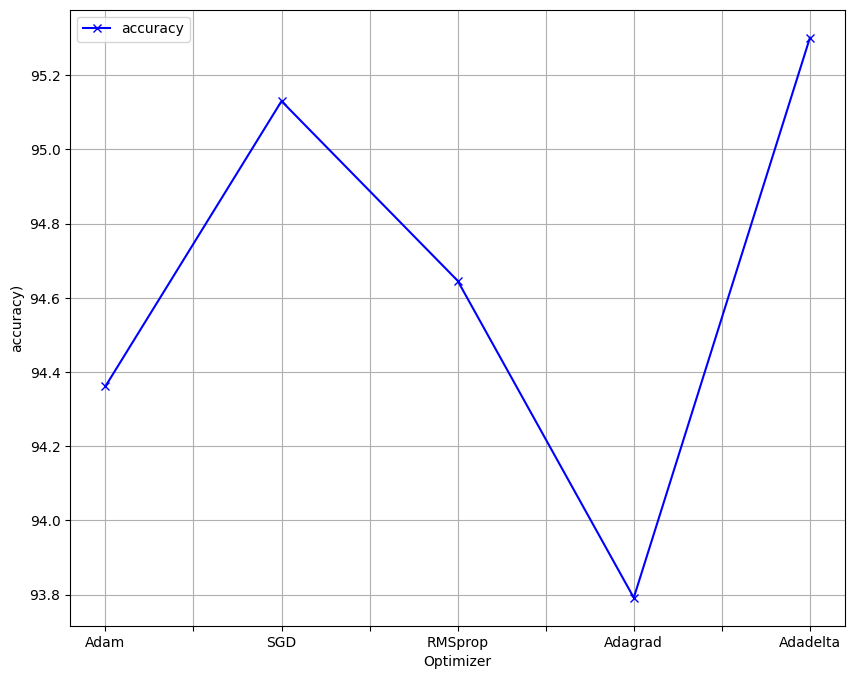

In [ ]:
from pylab import rcParams

# plot results
rcParams['figure.figsize'] = 10,8 # width 10, height 8

ax = accuracy_table.plot(x='optimizer', y='accuracy',style='bx-', grid=True)
ax.set_xlabel("Optimizer")
ax.set_ylabel("accuracy)")

In [ ]:
# Get optimum value for param
temp = accuracy_table[accuracy_table['accuracy'] == accuracy_table['accuracy'].max()]
optimizer_opt = temp[param_label].values[0]
print("max Accuracy = %0.3f" % accuracy_table['accuracy'].max())
print("optimum " + param_label + " = " + str(optimizer_opt))

max Accuracy = 95.301
optimum optimizer = Adadelta


In [ ]:
# Tuning the Dropout rate of the model
param_label = 'dropout_prob'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9]


accuracy_table = {param_label: [], 'accuracy': []}
tic = time.time()
for param in tqdm.tqdm_notebook(param_list):
    # Train, predict and evaluate model
    accuracy, _ = train_evaluate_the_model(train_generator_initial,val_generator_initial,optimizer_initial,epochs_initial,param,efnB7_basemodel) # replace epochs with 'epochs_initial'
    
    # Collect results
    accuracy_table[param_label].append(param)
    accuracy_table['accuracy'].append(accuracy)
    
accuracy_table = pd.DataFrame(accuracy_table) # convert the table to a dataframe
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
accuracy_table # display the resullts

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/4


<ipython-input-3-10783f5e508e>:79: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(generator=train_generator,


358/358 [==============================] - 217s 539ms/step - loss: 1.8555 - accuracy: 0.9106 - val_loss: 0.4737 - val_accuracy: 0.9113
Epoch 2/4
358/358 [==============================] - 137s 382ms/step - loss: 0.3219 - accuracy: 0.9486 - val_loss: 0.3377 - val_accuracy: 0.9210
Epoch 3/4
358/358 [==============================] - 137s 382ms/step - loss: 0.2763 - accuracy: 0.9427 - val_loss: 0.2301 - val_accuracy: 0.9502
Epoch 4/4
878/878 [==============================] - 99s 113ms/step - loss: 0.3753 - accuracy: 0.9526


ResourceExhaustedError: ignored

In [ ]:
from pylab import rcParams

# plot results
rcParams['figure.figsize'] = 10,8 # width 10, height 8

ax = accuracy_table.plot(x='dropout_prob', y='accuracy',style='bx-', grid=True)
ax.set_xlabel("dropout_prob")
ax.set_ylabel("accuracy)")

In [ ]:
# Get optimum value for param
temp = accuracy_table[accuracy_table['accuracy'] == accuracy_table['accuracy'].max()]
dropout_opt = temp[param_label].values[0]
print("max Accuracy = %0.3f" % accuracy_table['accuracy'].max())
print("optimum " + param_label + " = " + str(dropout_opt))

In [ ]:
#Tuning the batch size and epochs of the model
param_label = 'epochs'
param_list = [1,2,5,10] # [5, 10, 15, 20]

param2_label = 'batch_size'
param2_list = [8, 16] # [8, 16, 32] am using this batch sizes for now until we fix the accuracy issue, proper batch sizes to be use [8, 16, 32, 64, 128]

accuracy_table = {param_label: [], param2_label: [], 'accuracy': []}
tic = time.time()
for param in tqdm.tqdm_notebook(param_list):
    for param2 in tqdm_notebook(param2_list):
        
        # generate train and validation data
        train_generator,val_generator, _ = get_data_generator(train_dataset_path,validation_dataset_path,test_dataset_path, targetsize_constant, classmode_constant, param2)
        # train, predict and evaluate model
        accuracy, _ = train_evaluate_the_model(train_generator, val_generator, optimizer_initial, param,dropout_value_initial, efnB7_basemodel)
        
        # collect results
        accuracy_table[param_label].append(param)
        accuracy_table[param2_label].append(param2)
        accuracy_table['accuracy'].append(accuracy)
        
accuracy_table = pd.DataFrame(accuracy_table) # convert the table to a dataframe
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
accuracy_table # display the resullts

In [ ]:
from pylab import rcParams

# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = accuracy_table[accuracy_table[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='accuracy', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', '0.75']
for i in range(1,len(param2_list)):
    temp = accuracy_table[accuracy_table[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='accuracy', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("accuracy")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure
# ax.set_xlim([10, 50])
# ax.set_ylim([0, 5])

In [ ]:
# Get optimum value for param and param2
temp = accuracy_table[accuracy_table['accuracy'] == accuracy_table['accuracy'].max()]
epochs_opt = temp[param_label].values[0]
batch_size_opt = temp[param2_label].values[0]
print("max Accuracy = %0.3f" % accuracy_table['accuracy'].max())
print("optimum " + param_label + " = " + str(epochs_opt))
print("optimum " + param2_label + " = " + str(batch_size_opt))

In [ ]:
######
dropout_opt = 0.6
batch_size_opt = 16
epochs_opt = 10
optimizer_opt = 'Adagrad'
#####

In [ ]:
##Collecting all optimum tuned parameters
d = {'param': ['optimizer', 'epochs', 'batch_size','dropout_prob'],
     'original': [optimizer_initial, epochs_initial, batchsize_initial,dropout_value_initial],
     'after_tuning': [optimizer_opt, epochs_opt, batch_size_opt,dropout_opt]}
tuned_params = pd.DataFrame(d)
tuned_params

In [ ]:
#Creating the final Model with optimum parameters
# get train and validation data generator
train_generator_opt,val_generator_opt,test_generator_opt = get_data_generator(train_dataset_path,validation_dataset_path,test_dataset_path, targetsize_constant, classmode_constant, batch_size_opt)

# train and evaluate the model
accuracy, New_model = train_evaluate_the_model(train_generator_opt, val_generator_opt, optimizer_opt, epochs_opt,dropout_opt , efnB7_basemodel)


In [ ]:
accuracy

In [ ]:
#Saving the model for the webapp
New_model.save('brain_tumor_classification_efnB7_test10091335.hdf5') #28060904 - dd/mm/hours/minutes